### setup

In [2]:
import music21 as m21
import collections
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
filenames = glob.glob('data/note_csvs/*')

In [5]:
note_dfs = []
for file in filenames:
    note_dfs.append(pd.read_csv(file))

In [15]:
len(note_dfs)

31161

### prepare data

#### creating mappings

In [16]:
pitch_corpus = []
duration_corpus = []

for df in note_dfs:    
    pitch_corpus += list(df['pitch'])
    duration_corpus += list(df['duration'])

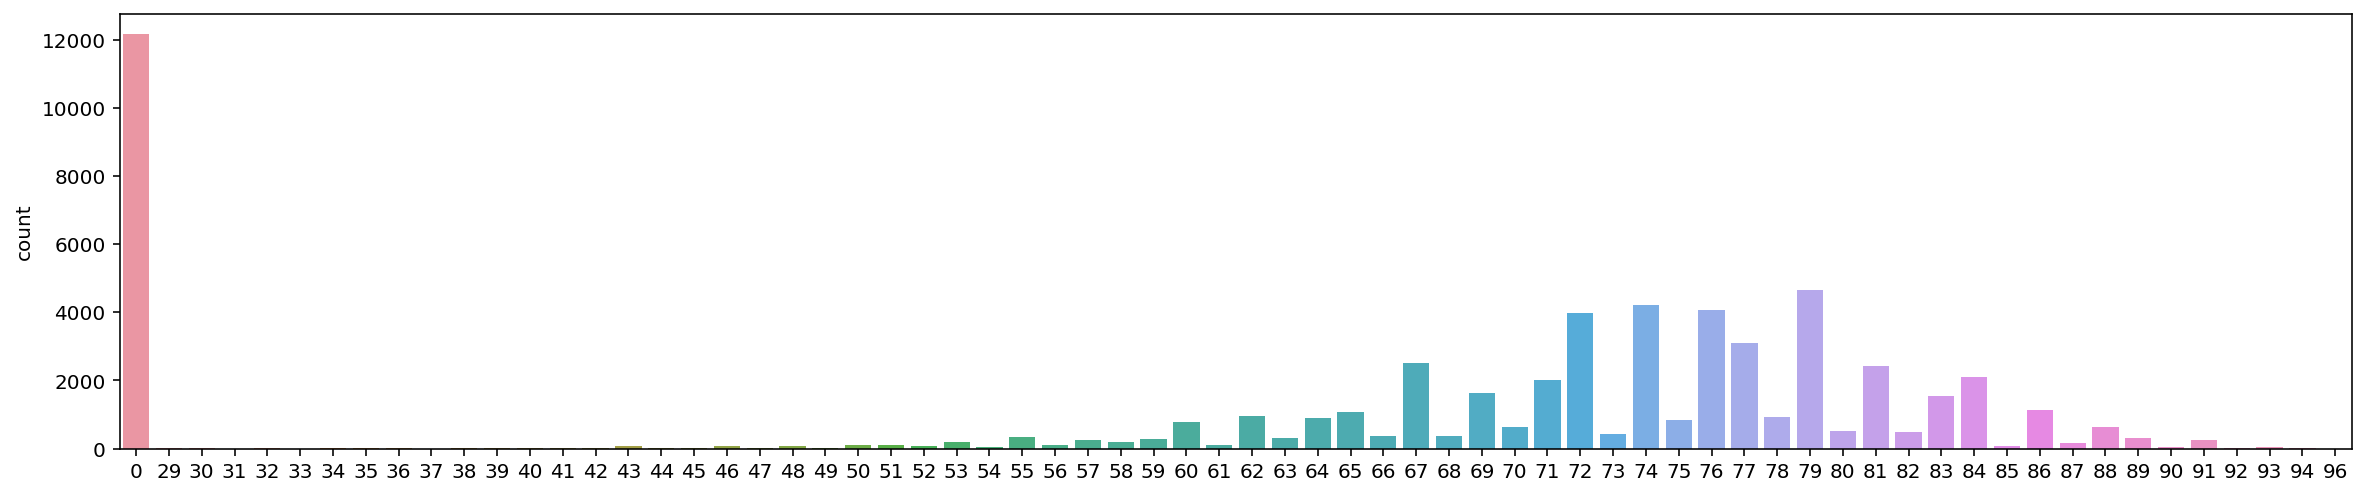

In [392]:
plt.figure(figsize=(20,4))
sns.countplot(x=pitch_corpus);

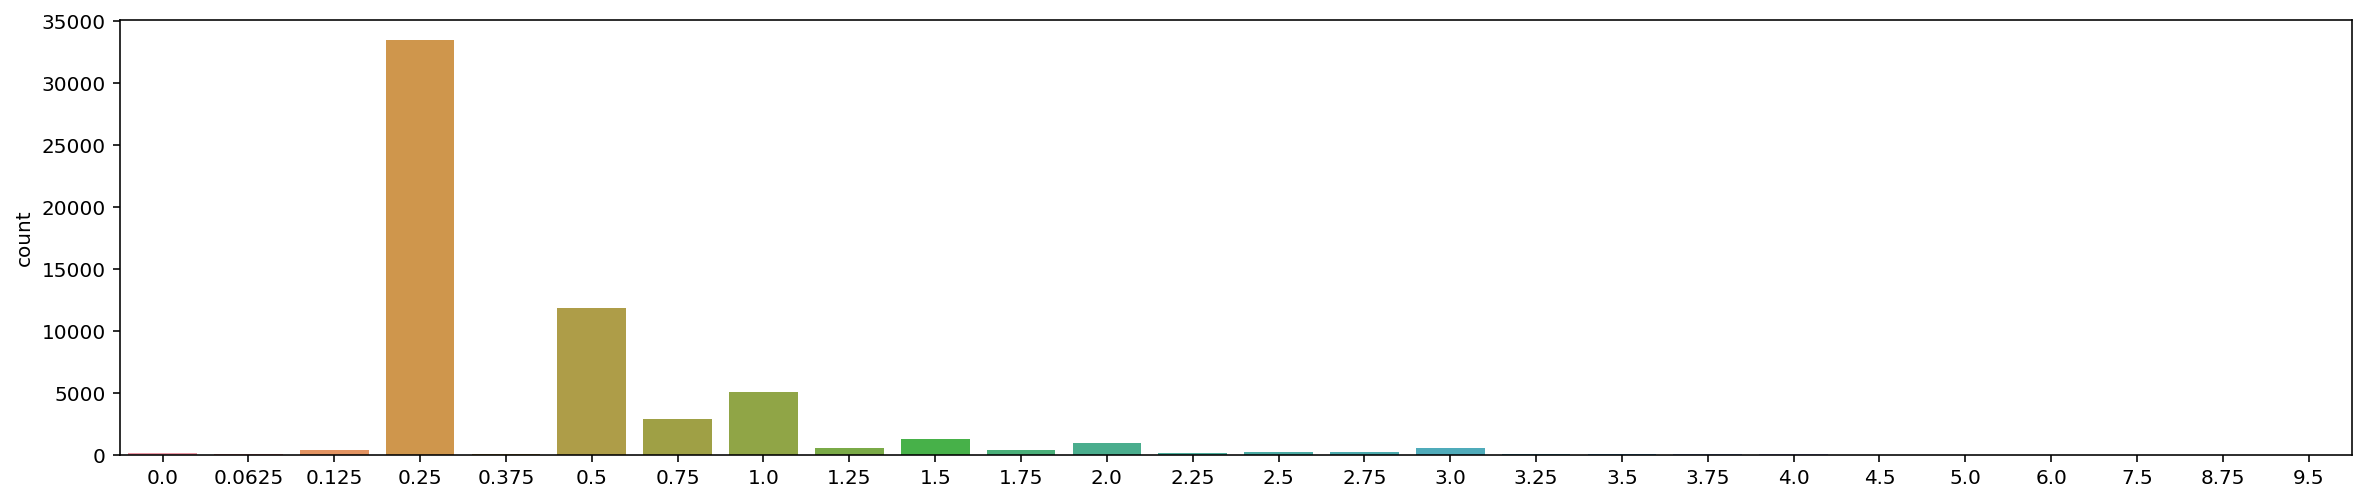

In [393]:
plt.figure(figsize=(20,4))
sns.countplot(x=duration_corpus);

In [19]:
pitch_count_num = collections.Counter(pitch_corpus)
duration_count_num = collections.Counter(duration_corpus)

print("Total notes in dataset:", len(pitch_corpus))
print("Total unique pitches in corpus:", len(pitch_count_num))
print("Total unique durations in corpus:", len(duration_count_num))

Total notes in dataset: 57980
Total unique pitches in corpus: 68
Total unique durations in corpus: 26


In [20]:
# Exploring the notes dictionary
Notes = list(pitch_count_num.keys())
Recurrence = list(pitch_count_num.values())

# Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 852.6470588235294
Most frequent note in Corpus appeared: 12153 times
Least frequent note in Corpus appeared: 2 time


In [21]:
# Storing all the unique characters present in the corpus to buid a mapping dict.
pitch_symb = sorted(list(set(pitch_corpus)))
duration_symb = sorted(list(set(duration_corpus)))

L_pitch_corpus = len(pitch_corpus)  # length of corpus
L_duration_corpus = len(duration_corpus)
L_pitch_symb = len(pitch_symb)  # length of total unique characters
L_duration_symb = len(duration_symb)

# Building dictionary to access the vocabulary from indices and vice versa
pitch_mapping = dict((int(c), i) for i, c in enumerate(pitch_symb))
pitch_reverse_mapping = dict((i, int(c)) for i, c in enumerate(pitch_symb))
duration_mapping = dict((float(c), i) for i, c in enumerate(duration_symb))
duration_reverse_mapping = dict((i, float(c)) for i, c in enumerate(duration_symb))

print("Total number of pitches:", L_pitch_corpus)
print("Number of unique pitches:", L_pitch_symb)
print("Total number of durations:", L_duration_corpus)
print("Number of unique durations:", L_duration_symb)

Total number of pitches: 57980
Number of unique pitches: 68
Total number of durations: 57980
Number of unique durations: 26


#### preprocessing data (my version)

In [483]:
# Splitting the corpus in equal length of strings and output target
length = 8
horizon = 1
features = []
target_pitch = []
target_duration = []
for df in note_dfs:
    L_df = len(df)
    if L_df <= length:
        continue
#     print(f"length of df: {L_df}")
    for i in range(0, L_df - (length), 1):
        feature = df[i:i+length][['pitch', 'duration']]
        feature_list = []
        for ind, val in feature.iterrows():
            feature_list.append([int(val.pitch), float(val.duration)])
        feature_mapped = [[pitch_mapping[val[0]], duration_mapping[val[1]]] for val in feature_list]
        features.append(feature_mapped)
        
        target_pitch.append(pitch_mapping[df['pitch'][i + length]])
        target_duration.append(duration_mapping[df['duration'][i + length]])
            
L_datapoints = len(target_pitch)
print("Total number of sequences in the corpus:", L_datapoints)

Total number of sequences in the corpus: 31891


In [489]:
# normalize X
X = X.astype('float')
X_norm[:, :, 0] = X[:, :, 0] / float(L_pitch_symb)
X_norm[:, :, 1] = X[:, :, 1] / float(L_duration_symb)

X_norm.shape

(31891, 8, 2)

In [530]:
y_pitch = np.array(target_pitch).reshape(-1,1)
y_duration = np.array(target_duration).reshape(-1,1)

In [531]:
y_pitch.shape

(31891, 1)

In [547]:
X_norm.shape

(31891, 8, 2)

In [548]:
#removing duplicates
X_norm_clean, X_ind = np.unique(X_norm, return_index=True, axis=0)
X_norm_clean.shape

(17333, 8, 2)

In [533]:
y_pitch_clean = y_pitch[X_ind]
y_duration_clean = y_duration[X_ind]
y_pitch_clean.shape

(17333, 1)

In [535]:
y = {"pitch_output": y_pitch_clean, "duration_output": y_duration_clean}

y['pitch_output'].shape

(17333, 1)

**getting class weights and preparing sample weights**

In [536]:
# class weights
pitch_counts = np.unique(np.array(target_pitch), return_counts=True)
duration_counts = np.unique(np.array(target_duration), return_counts=True)

pitch_class_weights_simple = {key:val for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights_simple = {key:val for key, val in zip(duration_counts[0], duration_counts[1])}
pitch_mean = np.mean(list(pitch_class_weights_simple.values()))
duration_mean = np.mean(list(duration_class_weights_simple.values()))
pitch_class_weights = {key:(1 / val) * pitch_mean for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights = {key:(1 / val) * duration_mean for key, val in zip(duration_counts[0], duration_counts[1])}

pcw = pitch_class_weights
dcw = duration_class_weights

pcw_keys = list(pitch_class_weights)
dcw_keys = list(duration_class_weights)

for i in range(max(pcw_keys)):
    if i not in pcw_keys:
        pcw[i] = 0

for i in range(max(dcw_keys)):
    if i not in dcw_keys:
        dcw[i] = 0

In [537]:
print(len(pcw))
print(len(dcw))

68
25


In [539]:
# sample weights
y_pitch_cw = np.array([pcw[pitch] for pitch in y_pitch_clean[:, 0]])
y_dur_cw = np.array([dcw[dur] for dur in y_duration_clean[:, 0]])

sample_weight = ((y_pitch_cw + y_dur_cw) / 2).reshape(-1, 1)
sample_weight.shape

(17333, 1)

#### preprocessing data (Alec's version)

In [634]:
long_dfs = [df for df in note_dfs if len(df) > 8]
len(long_dfs)

1089

In [619]:
# add -1's to the start of the df's

# def mask_start_df(df, pad_length):
#     mask_df = pd.DataFrame(np.full((pad_length, 4), -1), dtype = 'int64')
#     mask_df.columns = ['pitch','duration','beat','measure']
#     return pd.concat([mask_df, df])

In [621]:
# Splitting the corpus in equal length of strings and output target

def create_sequences(df_list, length, horizon = 1, selected_features = ['pitch', 'duration']):
    features_list = []
    target_pitch = []
    target_duration = []
    for note_df in df_list:
        df = note_df.copy()
        L_df = len(df)
#         df = mask_start_df(df, pad_length = (length // 2)) # add padding the to start of each data frame
        if L_df >= (length + horizon):
            df = df.reset_index()
            df['pitch'] = df['pitch'].astype('int') # to match dictionary keys
            df['duration'] = df['duration'].astype('float') # to match dictionary keys
            df['pitch'] = df['pitch'].map(pitch_mapping)
            df['duration'] = df['duration'].map(duration_mapping)
            latest_start_index = (L_df - length - horizon)
            for i in range(latest_start_index): 
                
                features = df.loc[i:(i + length - 1), selected_features] # minue one to exclude target
                features_list.append(features)
                pitch = df.loc[(i + length), 'pitch']
                target_pitch.append(pitch)
        
                duration = df.loc[(i + length), 'duration']
                target_duration.append(duration)

    L_datapoints = len(target_pitch)
    print("Total number of sequences in the corpus:", L_datapoints)
    
    return features_list, np.array(target_pitch), np.array(target_duration)

In [622]:
X, y_p, y_d = create_sequences(long_dfs, 8)

Total number of sequences in the corpus: 30802


In [624]:
y_p.shape

(30802,)

In [625]:
X_arr = np.array([np.array(df) for df in X])
X_arr.shape

(30802, 8, 2)

In [626]:
def uniqueish_indexes(X_arr, threshold = 25):
    _, unique_indexes, counts = np.unique(X_arr, axis = 0, return_index=True, return_counts = True)
    return [idx for idx, count in zip(unique_indexes, counts) if count < threshold]

In [627]:
indexes = uniqueish_indexes(X_arr, threshold = 25)
X, y_pitch, y_duration = X_arr[indexes], y_p[indexes], y_d[indexes]

In [635]:
y = {"pitch_output": y_pitch, "duration_output": y_duration}

In [636]:
print(y_pitch.shape)
print(X.shape)

(16654,)
(16654, 8, 2)


**getting class weights from Alec's functions**

In [629]:
# class weights
pitch_counts = np.unique(y_pitch, return_counts=True)
duration_counts = np.unique(y_duration, return_counts=True)

pitch_class_weights_simple = {key:val for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights_simple = {key:val for key, val in zip(duration_counts[0], duration_counts[1])}
pitch_mean = np.mean(list(pitch_class_weights_simple.values()))
duration_mean = np.mean(list(duration_class_weights_simple.values()))
pitch_class_weights = {int(key):(1 / val) * pitch_mean for key, val in zip(pitch_counts[0], pitch_counts[1])}
duration_class_weights = {int(key):(1 / val) * duration_mean for key, val in zip(duration_counts[0], duration_counts[1])}

pcw = pitch_class_weights
dcw = duration_class_weights

pcw_keys = list(pitch_class_weights)
dcw_keys = list(duration_class_weights)

for i in range(max(pcw_keys)):
    if i not in pcw_keys:
        pcw[i] = 0

for i in range(max(dcw_keys)):
    if i not in dcw_keys:
        dcw[i] = 0

In [630]:
# sample weights
y_pitch_cw = np.array([pcw[pitch] for pitch in y_pitch])
y_dur_cw = np.array([dcw[dur] for dur in y_duration])

sample_weight = ((y_pitch_cw + y_dur_cw) / 2).reshape(-1, 1)
sample_weight.shape

(16654, 1)

### modeling

#### Alec's model

In [631]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Dropout, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

input_shape = (8, 2)

def initialize_simple_model():
    
    input_layer = Input(shape=input_shape, name='input_layer')
#     masked_input = Masking(mask_value = -1)(input_layer)
    first_RNN = SimpleRNN(8, name='first_LSTM', activation='tanh')(input_layer)

    pitch_dense = Dense(4, name='pitch_dense', activation='relu')(first_RNN)
    pitch_dropout_2 = Dropout(0.3, name='pitch_dropout_2')(pitch_dense)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(pitch_dropout_2)


    duration_dense = Dense(4, name='duration_dense', activation='relu', )(first_RNN)
    duration_dropout_2 = Dropout(0.3, name='duration_dropout_2')(duration_dense)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(duration_dropout_2)

    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }

    loss_weights = {
        "pitch_output": 1.0, 
        "duration_output": 1.0
    }

    opt = Adam(learning_rate=0.0001)

    metric = SparseTopKCategoricalAccuracy(k=3, name='sparse_top_k_categorical_accuracy')

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics = metric)

    return model

In [633]:
alec_model = initialize_simple_model()
alec_model.summary()

Model: "functional_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
first_LSTM (SimpleRNN)          (None, 8)            88          input_layer[0][0]                
__________________________________________________________________________________________________
pitch_dense (Dense)             (None, 4)            36          first_LSTM[0][0]                 
__________________________________________________________________________________________________
duration_dense (Dense)          (None, 4)            36          first_LSTM[0][0]                 
______________________________________________________________________________________

In [637]:
es = EarlyStopping(patience=20, restore_best_weights=True)

history = alec_model.fit(X, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=500, 
                    verbose=1, 
                    callbacks=[es], 
                    sample_weight=sample_weight)

Epoch 1/500
833/833 [==============================] - 4s 5ms/step - loss: 7.6611 - pitch_output_loss: 4.2544 - duration_output_loss: 3.4068 - pitch_output_sparse_top_k_categorical_accuracy: 0.1070 - duration_output_sparse_top_k_categorical_accuracy: 0.0803 - val_loss: 6.5964 - val_pitch_output_loss: 3.7267 - val_duration_output_loss: 2.8696 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2171 - val_duration_output_sparse_top_k_categorical_accuracy: 6.0042e-04
Epoch 2/500
833/833 [==============================] - 4s 5ms/step - loss: 7.5651 - pitch_output_loss: 4.2343 - duration_output_loss: 3.3308 - pitch_output_sparse_top_k_categorical_accuracy: 0.1868 - duration_output_sparse_top_k_categorical_accuracy: 0.0872 - val_loss: 6.5134 - val_pitch_output_loss: 3.7078 - val_duration_output_loss: 2.8055 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2336 - val_duration_output_sparse_top_k_categorical_accuracy: 0.0012
Epoch 3/500
833/833 [==============================] - 4s 

In [641]:
def plot_curves(history):

    fig, axes = plt.subplots(2, 3, figsize = (12, 5))

    axes[0, 0].plot(history['loss'], label = 'Train')
    axes[0, 0].plot(history['val_loss'], label = 'Val')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(history['pitch_output_loss'], label = 'Train')
    axes[0, 1].plot(history['val_pitch_output_loss'], label = 'Val')
    axes[0, 1].set_title('Pitch Loss')
    axes[0, 1].legend()

    axes[0, 2].plot(history['duration_output_loss'], label = 'Train')
    axes[0, 2].plot(history['val_duration_output_loss'], label = 'Val')
    axes[0, 2].set_title('Duration Loss')
    axes[0, 2].legend()

    # axes[1, 0].plot(history['sparse_top_k_categorical_accuracy'])
    # axes[1, 0].plot(history['val_sparse_top_k_categorical_accuracy'])
    # axes[1, 0].set_title('Top K Acc')
    # axes[1, 0].legend();

    axes[1, 1].plot(history['pitch_output_sparse_top_k_categorical_accuracy'], label = 'Train')
    axes[1, 1].plot(history['val_pitch_output_sparse_top_k_categorical_accuracy'], label = 'Val')
    axes[1, 1].set_title('Pitch Top K Acc')
    axes[1, 1].legend()


    axes[1, 2].plot(history['duration_output_sparse_top_k_categorical_accuracy'], label = 'Train')
    axes[1, 2].plot(history['val_duration_output_sparse_top_k_categorical_accuracy'], label = 'Val')
    axes[1, 2].set_title('Duration Top K Acc')
    axes[1, 2].legend()
    plt.tight_layout();

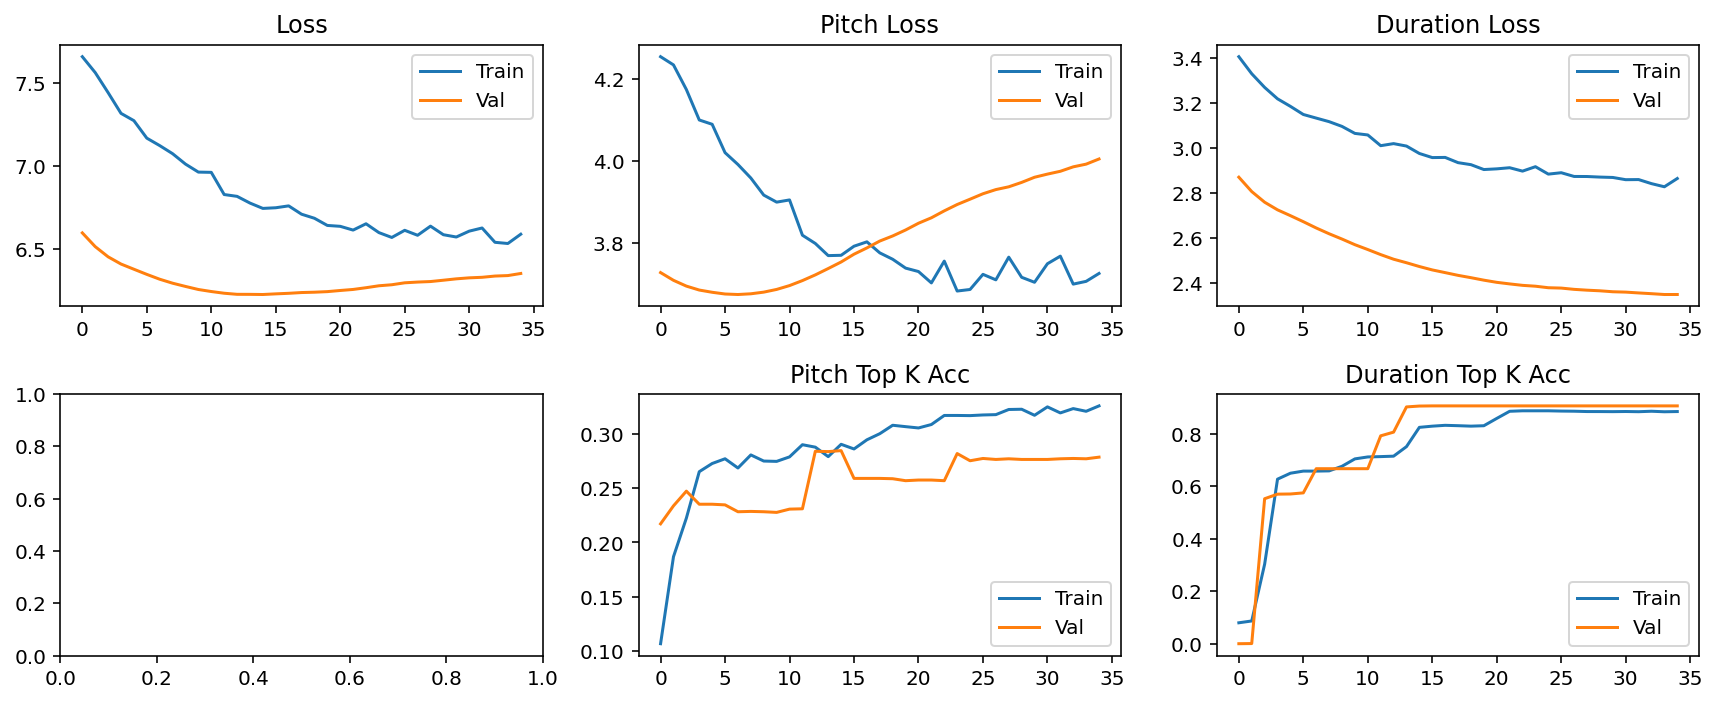

In [642]:
plot_curves(history.history)

In [643]:
model_2.save('model.h5')

#### Dense model

In [407]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=0.001)
metric = SparseTopKCategoricalAccuracy(k=3)

def initialize_dense_model():
    input_layer = Input(shape=X_norm.shape[1:], name='input_layer')
    reshape_layer = Reshape((X_norm.shape[-1] * X_norm.shape[-2],))(input_layer)
    first_dense = Dense(32, name='first_dense', activation='relu')(reshape_layer)
    hidden_dense = Dense(16, name='hidden_dense', activation='relu')(first_dense)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(hidden_dense)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(hidden_dense)
    
    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }

    loss_weights = {
        "pitch_output": 1.0, 
        "duration_output": 1.0
    }

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics=metric)
    
    return model

In [408]:
model_1 = initialize_dense_model()
model_1.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 100)          0           input_layer[0][0]                
__________________________________________________________________________________________________
first_dense (Dense)             (None, 32)           3232        reshape_7[0][0]                  
__________________________________________________________________________________________________
hidden_dense (Dense)            (None, 16)           528         first_dense[0][0]                
______________________________________________________________________________________

In [409]:
es = EarlyStopping(patience=20, restore_best_weights=True)

history = model_1.fit(X_norm, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=500, 
                    verbose=1, 
                    callbacks=[es], 
                    sample_weight=sample_weight)

Epoch 1/500
655/655 [==============================] - 2s 3ms/step - loss: 6.6521 - pitch_output_loss: 3.9739 - duration_output_loss: 2.6782 - pitch_output_sparse_top_k_categorical_accuracy: 0.2362 - duration_output_sparse_top_k_categorical_accuracy: 0.8713 - val_loss: 5.4454 - val_pitch_output_loss: 3.1029 - val_duration_output_loss: 2.3425 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3333 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9114
Epoch 2/500
655/655 [==============================] - 1s 2ms/step - loss: 6.0915 - pitch_output_loss: 3.6416 - duration_output_loss: 2.4499 - pitch_output_sparse_top_k_categorical_accuracy: 0.3468 - duration_output_sparse_top_k_categorical_accuracy: 0.9022 - val_loss: 5.5149 - val_pitch_output_loss: 3.1247 - val_duration_output_loss: 2.3902 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3459 - val_duration_output_sparse_top_k_categorical_accuracy: 0.8950
Epoch 3/500
655/655 [==============================] - 1s 2ms/

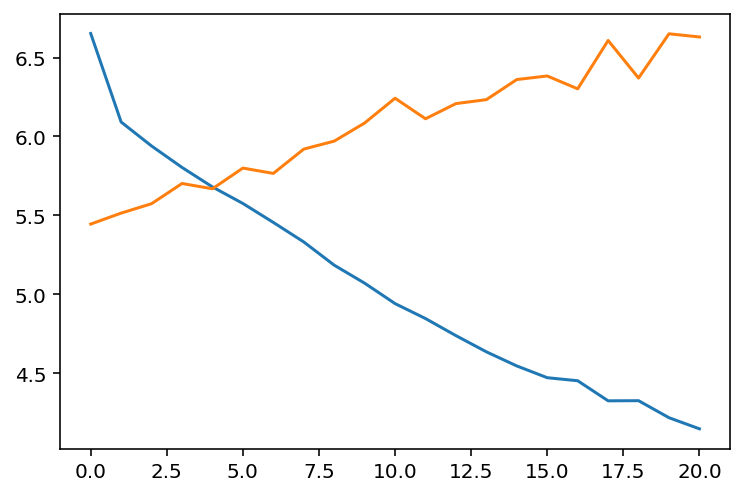

In [410]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss']);

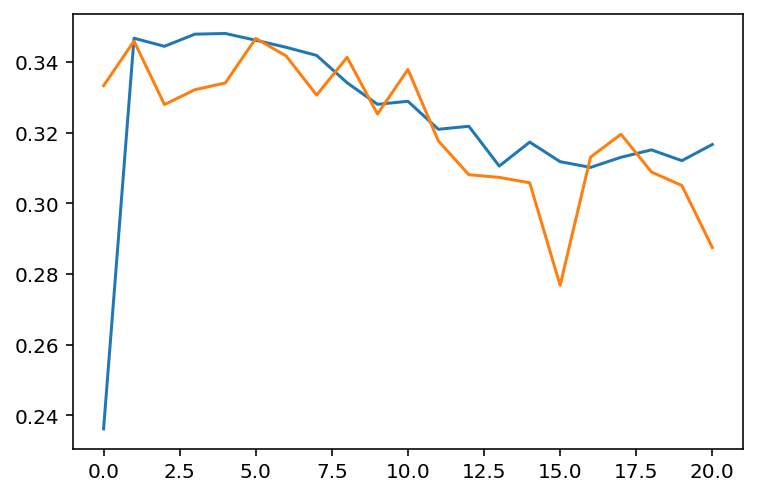

In [411]:
plt.plot(history.epoch, history.history['pitch_output_sparse_top_k_categorical_accuracy'])
plt.plot(history.epoch, history.history['val_pitch_output_sparse_top_k_categorical_accuracy']);

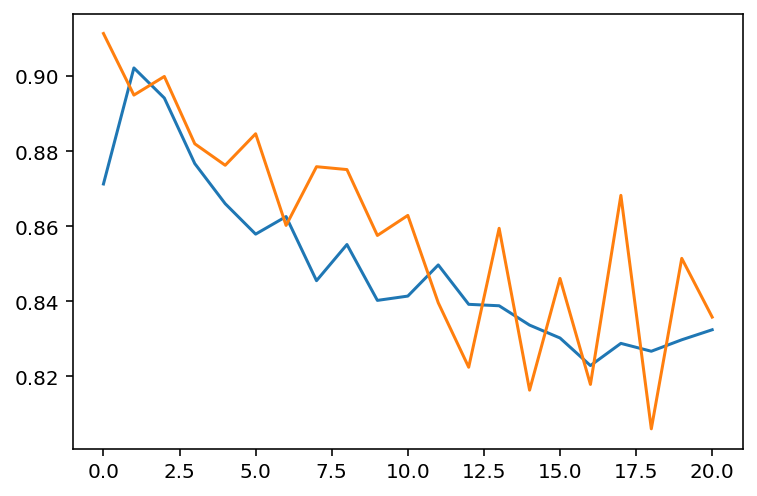

In [412]:
plt.plot(history.epoch, history.history['duration_output_sparse_top_k_categorical_accuracy'])
plt.plot(history.epoch, history.history['val_duration_output_sparse_top_k_categorical_accuracy']);

#### simple LSTM

In [541]:
def initialize_LSTM_model():
    input_layer = Input(shape=X_norm.shape[1:], name='input_layer')
    lstm_layer = LSTM(128, name='lstm_layer', activation='tanh')(input_layer)
    dropout_layer = Dropout(0.2, name='dropout_layer')(lstm_layer)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(dropout_layer)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])
    
    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }
    
    loss_weights = {
        "pitch_output": 0.05,
        "duration_output": 1.0
    }
    
    metric = SparseTopKCategoricalAccuracy(k=3)
    
    optimizer = Adam(learning_rate=0.005)
    
    model.compile(loss=losses, loss_weights=loss_weights, optimizer=optimizer, metrics=metric)
    
    return model
    

In [542]:
model_2 = initialize_LSTM_model()
model_2.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 8, 2)]       0                                            
__________________________________________________________________________________________________
lstm_layer (LSTM)               (None, 128)          67072       input_layer[0][0]                
__________________________________________________________________________________________________
dropout_layer (Dropout)         (None, 128)          0           lstm_layer[0][0]                 
__________________________________________________________________________________________________
pitch_output (Dense)            (None, 68)           8772        dropout_layer[0][0]              
______________________________________________________________________________________

In [549]:
es = EarlyStopping(patience=15, restore_best_weights=True)

history_2 = model_2.fit(X_norm_clean, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=100, 
                    verbose=1, 
#                     callbacks=[es], 
                    sample_weight=sample_weight)

Epoch 1/100
867/867 [==============================] - 10s 11ms/step - loss: 3.0235 - pitch_output_loss: 3.9166 - duration_output_loss: 2.8276 - pitch_output_sparse_top_k_categorical_accuracy: 0.3035 - duration_output_sparse_top_k_categorical_accuracy: 0.7902 - val_loss: 3.1634 - val_pitch_output_loss: 6.1766 - val_duration_output_loss: 2.8546 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2700 - val_duration_output_sparse_top_k_categorical_accuracy: 0.7465
Epoch 2/100
867/867 [==============================] - 9s 11ms/step - loss: 3.0550 - pitch_output_loss: 3.9400 - duration_output_loss: 2.8580 - pitch_output_sparse_top_k_categorical_accuracy: 0.2984 - duration_output_sparse_top_k_categorical_accuracy: 0.8015 - val_loss: 3.0079 - val_pitch_output_loss: 6.2763 - val_duration_output_loss: 2.6941 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.2593 - val_duration_output_sparse_top_k_categorical_accuracy: 0.8284
Epoch 3/100
867/867 [==============================] - 9s 1

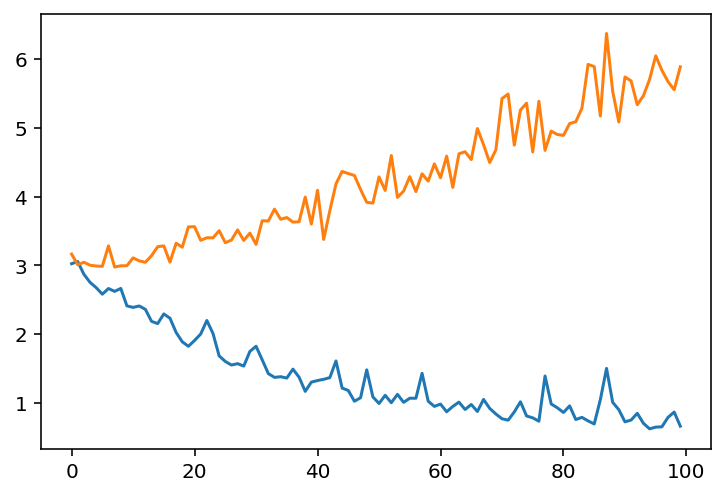

In [550]:
plt.plot(history_2.epoch, history_2.history['loss'])
plt.plot(history_2.epoch, history_2.history['val_loss']);

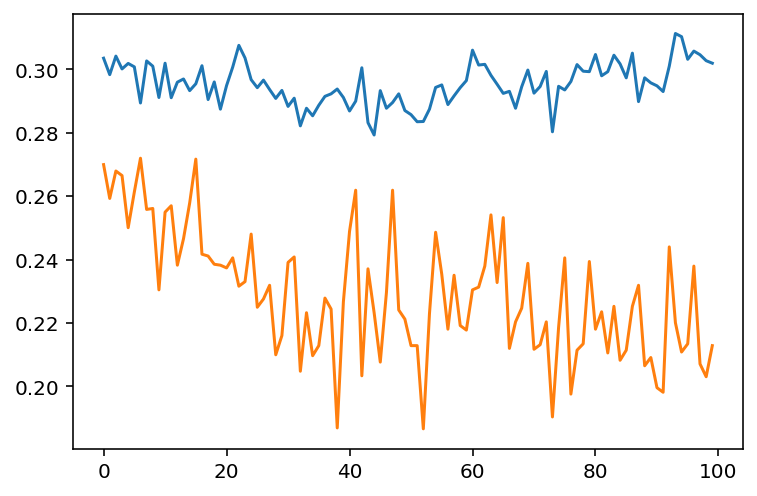

In [551]:
plt.plot(history_2.epoch, history_2.history['pitch_output_sparse_top_k_categorical_accuracy'])
plt.plot(history_2.epoch, history_2.history['val_pitch_output_sparse_top_k_categorical_accuracy']);

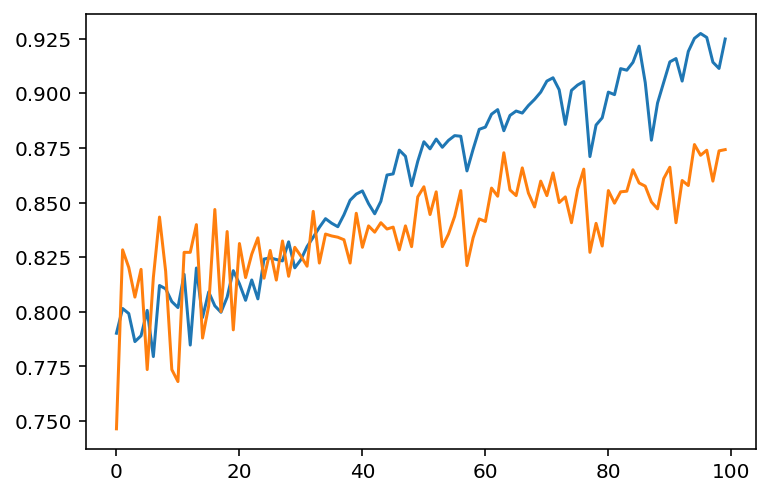

In [552]:
plt.plot(history_2.epoch, history_2.history['duration_output_sparse_top_k_categorical_accuracy'])
plt.plot(history_2.epoch, history_2.history['val_duration_output_sparse_top_k_categorical_accuracy']);

In [557]:
def plot_curves(history):

    fig, axes = plt.subplots(1, 3, figsize = (15, 5))

    axes[0].plot(history.history['loss'], label = 'Train')
    axes[0].plot(history.history['val_loss'], label = 'Val')
    axes[0].set_title('Loss')
    axes[0].legend();

    axes[1].plot(history.history['pitch_output_loss'], label = 'Train')
    axes[1].plot(history.history['val_pitch_output_loss'], label = 'Val')
    axes[1].set_title('Pitch Loss')
    axes[1].legend();

    axes[2].plot(history.history['duration_output_loss'], label = 'Train')
    axes[2].plot(history.history['val_duration_output_loss'], label = 'Val')
    axes[2].set_title('Duration Loss')
    axes[2].legend();

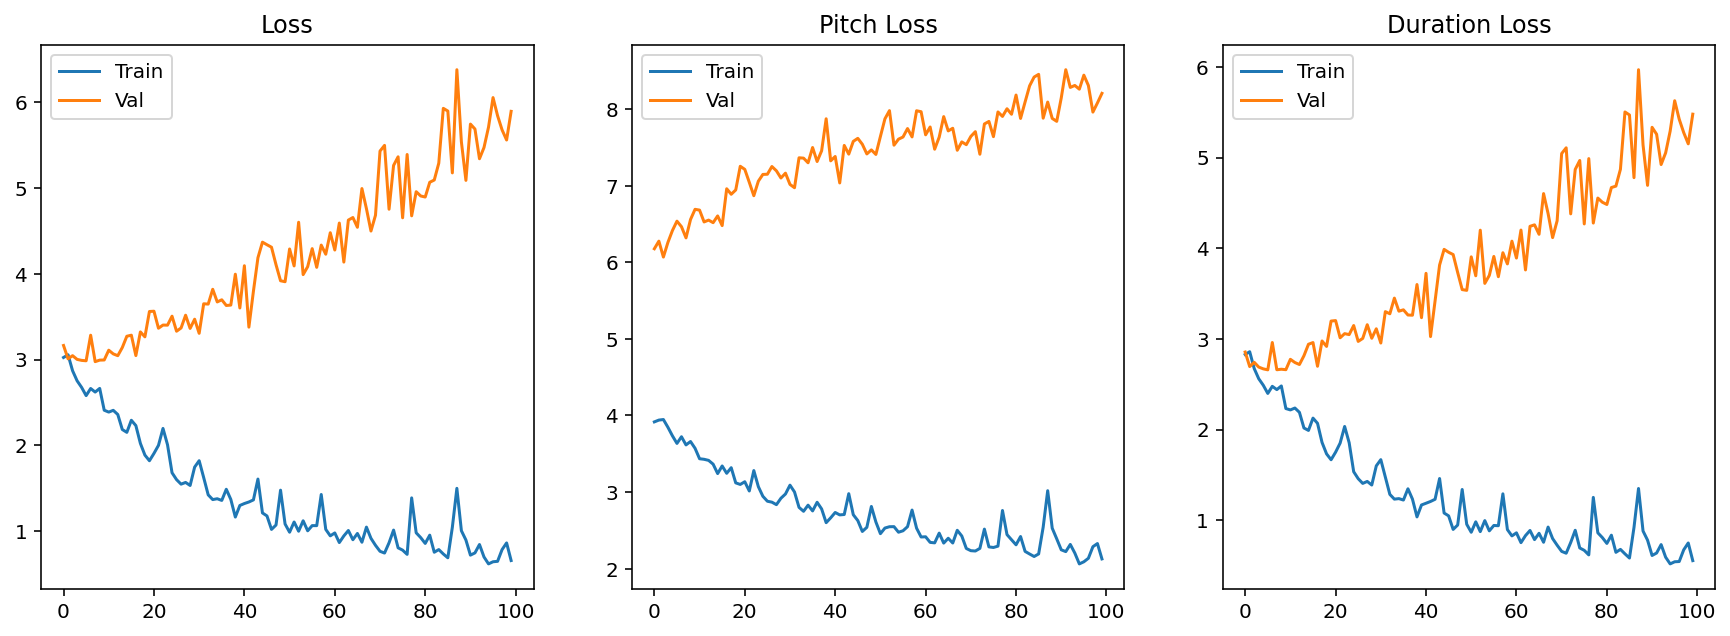

In [558]:
plot_curves(history_2)

In [503]:
model_2.save('model.h5')

#### complex lstm model

In [419]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

opt = Adam(learning_rate=0.001)
metric = SparseTopKCategoricalAccuracy(k=3, name='sparse_top_k_categorical_accuracy')

def initialize_model():
    
    input_layer = Input(shape=X_norm.shape[1:], name='input_layer')
    first_LSTM = LSTM(64, name='first_LSTM', activation='tanh', return_sequences=True)(input_layer)
#     first_dropout = Dropout(0.1, name='first_dropout')(first_LSTM)

    pitch_LSTM = LSTM(64, name='pitch_LSTM', activation='tanh')(first_LSTM)
    pitch_dropout = Dropout(0.2, name='pitch_dropout')(pitch_LSTM)
    pitch_dense = Dense(32, name='pitch_dense', activation='tanh')(pitch_dropout)
    pitch_dropout_2 = Dropout(0.4, name='pitch_dropout_2')(pitch_dense)
    pitch_output = Dense(len(pcw), name='pitch_output', activation='softmax')(pitch_dropout_2)


    duration_LSTM = LSTM(32, name='duration_LSTM', activation='tanh')(first_LSTM)
    duration_dropout = Dropout(0.2, name='duration_dropout')(duration_LSTM)
    duration_dense = Dense(16, name='duration_dense', activation='tanh')(duration_dropout)
    duration_dropout_2 = Dropout(0.4, name='duration_dropout_2')(duration_dense)
    duration_output = Dense(len(dcw), name='duration_output', activation='softmax')(duration_dropout_2)

    model = Model(inputs=input_layer, outputs=[pitch_output, duration_output])

    losses = {
        "pitch_output": "sparse_categorical_crossentropy",
        "duration_output": "sparse_categorical_crossentropy",
    }

    loss_weights = {
        "pitch_output": 0.2, 
        "duration_output": 1.0
    }

    model.compile(optimizer=opt, loss=losses, loss_weights=loss_weights, metrics = metric)

    return model

In [420]:
model_3 = initialize_model()
model_3.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
first_LSTM (LSTM)               (None, 50, 64)       17152       input_layer[0][0]                
__________________________________________________________________________________________________
pitch_LSTM (LSTM)               (None, 64)           33024       first_LSTM[0][0]                 
__________________________________________________________________________________________________
duration_LSTM (LSTM)            (None, 32)           12416       first_LSTM[0][0]                 
______________________________________________________________________________________

In [162]:
from tensorflow.keras.utils import plot_model
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [421]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=15, restore_best_weights=True)

history_3 = model_3.fit(X_norm, 
                    y, 
                    validation_split=0.2, 
                    shuffle=True, 
                    batch_size=16, 
                    epochs=500, 
                    verbose=1, 
                    callbacks=[es], 
                    sample_weight=sample_weight)

Epoch 1/500
655/655 [==============================] - 61s 93ms/step - loss: 3.5123 - pitch_output_loss: 3.9499 - duration_output_loss: 2.7224 - pitch_output_sparse_top_k_categorical_accuracy: 0.3097 - duration_output_sparse_top_k_categorical_accuracy: 0.8192 - val_loss: 3.0005 - val_pitch_output_loss: 3.1135 - val_duration_output_loss: 2.3777 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3375 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9114
Epoch 2/500
655/655 [==============================] - 72s 110ms/step - loss: 3.3418 - pitch_output_loss: 3.7716 - duration_output_loss: 2.5875 - pitch_output_sparse_top_k_categorical_accuracy: 0.3308 - duration_output_sparse_top_k_categorical_accuracy: 0.8720 - val_loss: 3.0623 - val_pitch_output_loss: 3.1138 - val_duration_output_loss: 2.4396 - val_pitch_output_sparse_top_k_categorical_accuracy: 0.3158 - val_duration_output_sparse_top_k_categorical_accuracy: 0.9114
Epoch 3/500
655/655 [==============================] - 52

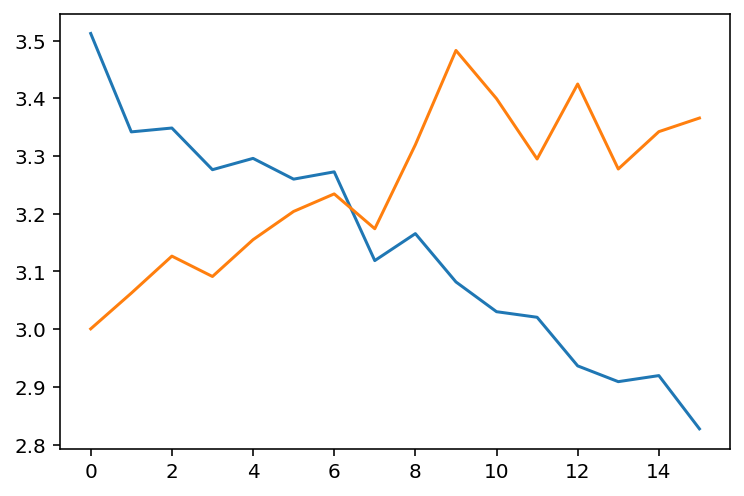

In [422]:
plt.plot(history_3.epoch, history_3.history['loss'])
plt.plot(history_3.epoch, history_3.history['val_loss']);

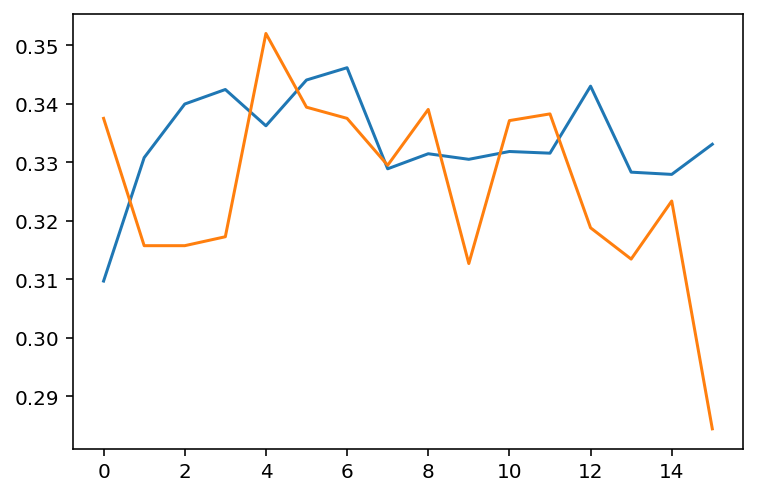

In [423]:
plt.plot(history_3.epoch, history_3.history['pitch_output_sparse_top_k_categorical_accuracy'])
plt.plot(history_3.epoch, history_3.history['val_pitch_output_sparse_top_k_categorical_accuracy']);

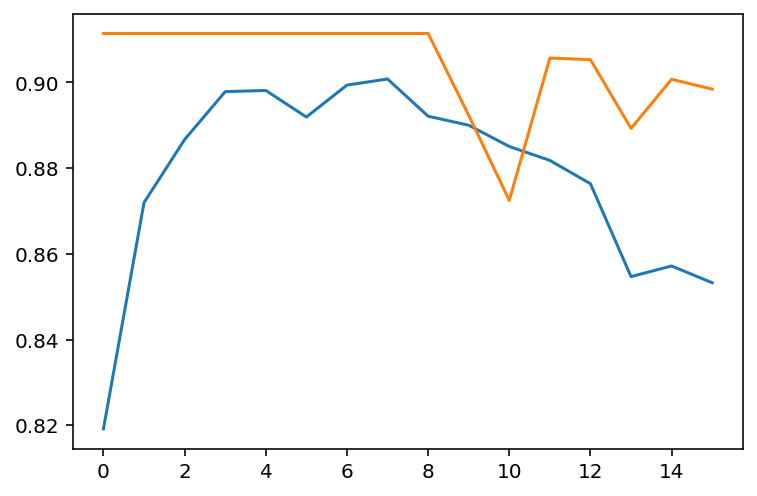

In [424]:
plt.plot(history_3.epoch, history_3.history['duration_output_sparse_top_k_categorical_accuracy'])
plt.plot(history_3.epoch, history_3.history['val_duration_output_sparse_top_k_categorical_accuracy']);

### generate notes

#### how temperature, logits, and tf.random.categorical work

<AxesSubplot:xlabel='0', ylabel='count'>

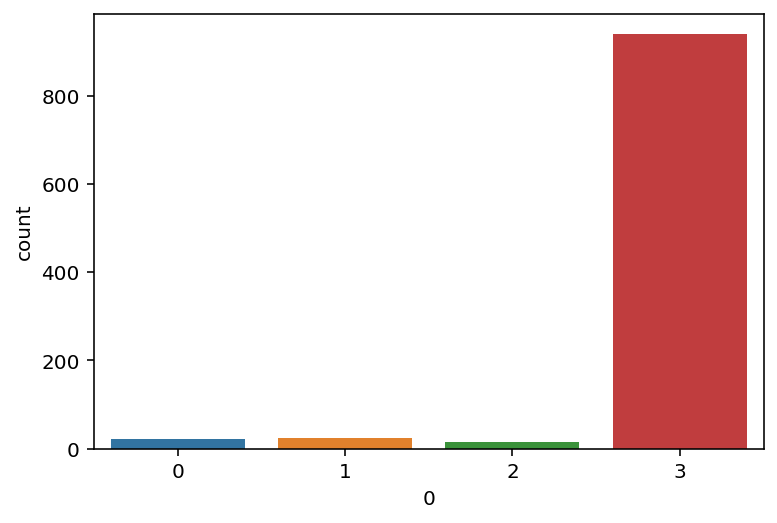

In [646]:
from tensorflow import random

temperature = 0.5  # randomness (higher value above 1 = more random, smaller value below 1 = less random)
logits = np.array([[0.0001, 0.1, 0, 2]]) / temperature

preds = []
for i in range(1000):
    preds.append(np.array(random.categorical(logits, 1)).reshape(-1))

import seaborn as sns

preds_df = pd.DataFrame(preds)

sns.countplot(data=preds_df, x=0)

**how to get 3 random (weighted) notes from top 12 notes**

In [362]:
temperature = 2.0
sample = X_norm[0].reshape(1, length, 2)
pitch_pred, duration_pred = model.predict(sample)
pitch_pred[0] /= temperature
pitch_index_top_12 = np.argpartition(pitch_pred[0], -12)[-12:]
pitch_index_top_12

array([37, 56, 43, 49, 53, 50, 48, 51, 46, 44, 39,  0])

In [364]:
pitch_logits_top_12 = np.array([pitch_pred[0][i] for i in pitch_index_top_12]).reshape(-1, 12)

array([[0.00909219, 0.01031377, 0.0091727 , 0.01460877, 0.01332568,
        0.01022976, 0.01891692, 0.02775377, 0.0208681 , 0.0221001 ,
        0.02099754, 0.1022405 ]], dtype=float32)

In [388]:
pitch_3_logit_ind = np.array(random.categorical(pitch_logits_top_10, 3)).reshape(-1)
pitch_index_top_3 = [pitch_index_top_12[i] for i in pitch_3_logit_ind]
pitch_index_top_3

[48, 44, 51]

#### Generate notes (good version)

In [647]:
from tensorflow import random

note_count = 5
temperature = 0.05  # randomness
note_choices = []
Music = []
notes_generated = []
sample = X_norm[0].reshape(1, length, 2)
for i in range(note_count):

    # return predictions from sample
    pitch_pred, duration_pred = alec_model.predict(sample)

    # apply randomness level to pitch
    pitch_pred[0] /= temperature

    # get 3 random (weighted) indexes from top 12 pitch logits
    pitch_index_top_12 = np.argpartition(pitch_pred[0], -12)[-12:]
    pitch_logits_top_12 = np.array([pitch_pred[0][i] for i in pitch_index_top_12]).reshape(-1, 12)
    pitch_3_logit_ind = np.array(random.categorical(pitch_logits_top_10, 3)).reshape(-1)
    pitch_index_top_3 = [pitch_index_top_12[i] for i in pitch_3_logit_ind]
    
    dur_index_top_2 = np.argpartition(duration_pred[0], -2)[-2:]  

    # return three notes as [pitch, duration] pairs
    three_notes = [[pitch, np.random.choice(dur_index_top_2)] for pitch in pitch_index_top_3]
    three_notes_mapped = [[pitch_reverse_mapping[pitch], duration_reverse_mapping[duration]] for pitch, duration in three_notes]    
    note_choices.append(three_notes_mapped)

    # prompt user to choose notes
    print(three_notes_mapped)
    choice = input('choose 0, 1, or 2:')

    # next note (user friendly)
    next_note = three_notes_mapped[int(choice)]
    Music.append(next_note)

    # next note (model friendly)
    next_note_mapped = [pitch_mapping[next_note[0]], duration_mapping[next_note[1]]]
    notes_generated.append(next_note_mapped)
    next_note_norm = [next_note_mapped[0] / float(L_pitch_symb), next_note_mapped[1] / float(L_duration_symb)]
    
    # update sample with next note
    sample = np.insert(sample[0], len(sample[0]), next_note_norm, axis=0)[1:].reshape(1, length, 2)



[[71, 0.5], [65, 0.25], [74, 0.5]]
choose 0, 1, or 2:0
[[79, 0.5], [65, 0.25], [79, 0.5]]
choose 0, 1, or 2:0
[[64, 0.25], [79, 0.5], [69, 0.5]]
choose 0, 1, or 2:2
[[69, 0.5], [74, 0.25], [79, 0.5]]
choose 0, 1, or 2:0
[[67, 0.25], [67, 0.5], [65, 0.5]]
choose 0, 1, or 2:0


In [648]:
Music

[[71, 0.5], [79, 0.5], [69, 0.5], [69, 0.5], [67, 0.25]]

#### Generate notes (old bad version)

In [397]:
note_count = 5
note_choices = []
Music = []
notes_generated = []
sample = X_norm[0].reshape(1, length, 2)
for i in range(note_count):

    # return predictions from sample
    pitch_pred, duration_pred = model.predict(sample)

    # get log of predictions
    pitch_pred = np.log(pitch_pred[0]) / 1.0  # diversity?
    duration_pred = np.log(duration_pred[0])

    # un-log predictions (not sure why we logged them...)
    exp_pitch_preds = np.exp(pitch_pred)
    exp_duration_preds = np.exp(duration_pred)

    # make odds of all predictions = 1.0
    pitch_pred = exp_pitch_preds / np.sum(exp_pitch_preds)
    duration_pred = exp_duration_preds / np.sum(exp_duration_preds)

    # get top 3 pitch predictions and top 2 duration predictions
    pitch_index_top_3 = np.argpartition(pitch_pred, -3)[-3:]
    dur_index_top_2 = np.argpartition(duration_pred, -2)[-2:]

    # return three notes as [pitch, duration] pairs
    three_notes = [[pitch, np.random.choice(dur_index_top_2)] for pitch in pitch_index_top_3]
    three_notes_mapped = [[pitch_reverse_mapping[pitch], duration_reverse_mapping[duration]] for pitch, duration in three_notes]    
    note_choices.append(three_notes_mapped)

    print(three_notes_mapped)
    choice = input('choose 0, 1, or 2:')

    next_note = three_notes_mapped[int(choice)]
    Music.append(next_note)

    next_note_mapped = [pitch_mapping[next_note[0]], duration_mapping[next_note[1]]]
    notes_generated.append(next_note_mapped)

    next_note_norm = [next_note_mapped[0] / float(L_pitch_symb), next_note_mapped[1] / float(L_duration_symb)]
    sample = np.insert(sample[0], len(sample[0]), next_note_norm, axis=0)[1:].reshape(1, length, 2)



[[72, 0.25], [79, 0.25], [0, 0.25]]
choose 0, 1, or 2:0
[[72, 0.25], [79, 0.5], [0, 0.5]]
choose 0, 1, or 2:0
[[72, 0.25], [79, 0.5], [0, 0.25]]
choose 0, 1, or 2:0
[[72, 0.25], [79, 0.5], [0, 0.5]]
choose 0, 1, or 2:0
[[72, 0.25], [79, 0.25], [0, 0.5]]
choose 0, 1, or 2:0


In [387]:
Music

[[72, 0.25], [79, 0.5], [72, 0.25], [72, 0.25], [79, 0.25]]

### useful code

In [ ]:
s = m21.corpus.parse('bach/bwv65.2.xml')

s.analyze('key')

f = m21.note.Note("F5")
f

f.pitch.frequency

bflat = m21.pitch.Pitch('b-4')

bflat.unicodeName

haydn = m21.corpus.getComposer('haydn')

mozart = m21.corpus.getComposer('mozart')

song = m21.instrument.partitionByInstrument(s)

In [ ]:
mozart_1 = m21.corpus.search('mozart')[3].parse()

mozart_1.show('midi')